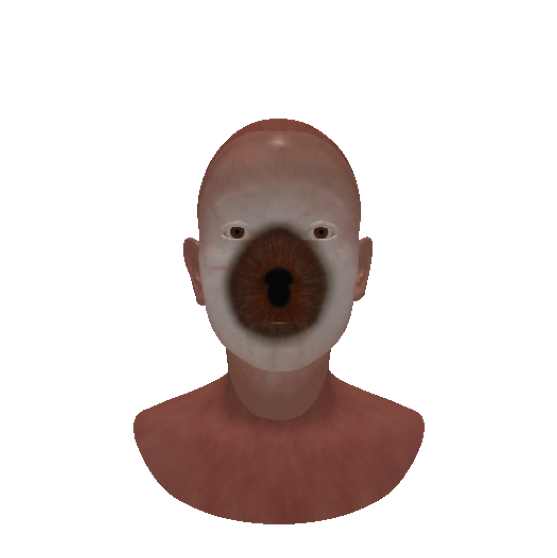

In [1]:
import torch
from pytorch3d.io import load_objs_as_meshes
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras,
    PointLights,
    RasterizationSettings,
    MeshRenderer,
    MeshRasterizer,
    SoftPhongShader
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
R, T = look_at_view_transform(2, 0, 0)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

raster_settings = RasterizationSettings(
    image_size=512,
    blur_radius=0.0,
    faces_per_pixel=1,
)

lights = PointLights(ambient_color=((0.8, 0.8, 0.8),), device=device, location=[[0.0, 0.0, 2.0]])

renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras,
        raster_settings=raster_settings
    ),
    shader=SoftPhongShader(
        device=device,
        cameras=cameras,
        lights=lights
    )
)


def render(obj_path):
    meshes = load_objs_as_meshes([obj_path], device=device, load_textures=True)
    verts = meshes.verts_packed()
    center = verts.mean(0)
    scale = max((verts - center).abs().max(0)[0])
    meshes.offset_verts_(-center)
    meshes.scale_verts_((1.0 / float(scale)))
    return renderer(meshes)


def render_three_view(obj_path):
    meshes = load_objs_as_meshes([obj_path], device=device)
    meshes = meshes.extend(3)
    verts = meshes.verts_packed()
    center = verts.mean(0)
    scale = max((verts - center).abs().max(0)[0])
    meshes.offset_verts_(-center)
    meshes.scale_verts_((1.0 / float(scale)))
    azim = torch.linspace(-45, 45, 3)
    R, T = look_at_view_transform(dist=2, azim=azim)
    three_view_cameras = FoVPerspectiveCameras(device=device, R=R, T=T)
    return renderer(meshes, cameras=three_view_cameras)


def render_batch_view(obj_path, batch_size=20):
    meshes = load_objs_as_meshes([obj_path], device=device)
    meshes = meshes.extend(batch_size)
    verts = meshes.verts_packed()
    center = verts.mean(0)
    scale = max((verts - center).abs().max(0)[0])
    meshes.offset_verts_(-center)
    meshes.scale_verts_((1.0 / float(scale)))
    elev = torch.linspace(0, 180, batch_size)
    azim = torch.linspace(-180, 180, batch_size)
    R, T = look_at_view_transform(dist=2, azim=azim, elev=elev)
    batch_view_cameras = FoVPerspectiveCameras(device=device, R=R, T=T)
    return renderer(meshes, cameras=batch_view_cameras)


def render_with_certain_view(obj_path, elev=90, azim=0):
    meshes = load_objs_as_meshes([obj_path], device=device, load_textures=True)
    verts = meshes.verts_packed()
    center = verts.mean(0)
    scale = max((verts - center).abs().max(0)[0])
    meshes.offset_verts_(-center)
    meshes.scale_verts_((1.0 / float(scale)))
    elev = elev
    azim = azim
    R, T = look_at_view_transform(dist=2, azim=azim, elev=elev)
    view_cameras = FoVPerspectiveCameras(device=device, R=R, T=T)
    return renderer(meshes, cameras=view_cameras)
    


from matplotlib import pyplot as plt
obj_path = 'data/amelia/amelia2.obj'

images = render_with_certain_view(obj_path, elev=-90, azim=180)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.axis("off")
plt.show()


In [2]:
import os

import numpy as np
import cv2
from PIL import Image
from tqdm import tqdm

In [3]:
def get_concat_h(im1, im2):
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

def concat_head_eyes_texture(head_texture_file, eyes_texture_file, save_path):
    texture_size = (256, 256)

    head_texture = Image.open(head_texture_file).resize(texture_size)
    eyes_texture = Image.open(eyes_texture_file).resize(texture_size)
    
    head_texture.save(f'{head_texture_file.split(".")[0]}_256.png')
    eyes_texture.save(f'{eyes_texture_file.split(".")[0]}_256.png')
    get_concat_h(head_texture, eyes_texture).save(save_path)

In [4]:
def generate_new_obj(obj_path, mtl_path, save_path):
    with open(obj_path, 'r') as f:
        with open(save_path, 'w') as new_f:
            lines = [l for l in f.readlines() if l[0] != '#' and len(l) > 1]
            new_lines=list()

            new_lines.append(f'mtllib {mtl_path}\n')
            new_lines.extend([l for l in lines if l[:2] == 'v '])

            def generate_new_vt(l, left=True):
                l = l[:-1]
                x_pos, y_pos = l.split(' ')[1:]
                x_pos = float(x_pos)
                x_pos /= 2
                if not left:
                    x_pos += .5
                new_l = f'vt {x_pos} {y_pos}\n'

                return new_l

            start = 0
            see_f = False
            for i in range(start, len(lines)):
                l = lines[i]
                if l[:3] == 'vt ':
                    see_f = True

                    new_lines.append(generate_new_vt(l))
                elif see_f:
                    break

            start = i
            see_f = False
            for i in range(start, len(lines)):
                l = lines[i]
                if l[:3] == 'vt ':
                    see_f = True

                    new_lines.append(generate_new_vt(l, False))
                elif see_f:
                    break

            start = i
            see_f = False
            for i in range(start, len(lines)):
                l = lines[i]
                if l[:3] == 'vt ':
                    see_f = True

                    new_lines.append(generate_new_vt(l, False))
                elif see_f:
                    break

            new_lines.extend([l for l in lines if l[:3] == 'vn '])
            new_lines.extend([
                '\n',
                'o head\n',
                'g head\n',
                'usemtl shader_head_eyes_shaderSG\n',
                's 1\n',
            ])
            start = 0
            see_f = False
            for i in range(start, len(lines)):
                l = lines[i]
                if l[:2] == 'f ':
                    see_f = True
                    new_lines.append(l)
                elif see_f:
                    break

            new_lines.extend([
                '\n',
                'o eyeLeft\n',
                'g eyeLeft\n',
                'usemtl shader_head_eyes_shaderSG\n',
                's 1\n',
            ])
            start = i
            see_f = False
            for i in range(start, len(lines)):
                l = lines[i]
                if l[:2] == 'f ':
                    see_f = True
                    new_lines.append(l)
                elif see_f:
                    break

            new_lines.extend([
                '\n',
                'o eyeRight\n',
                'g eyeRight\n',
                'usemtl shader_head_eyes_shaderSG\n',
                's 1\n',
            ])
            start = i
            see_f = False
            for i in range(start, len(lines)):
                l = lines[i]
                if l[:2] == 'f ':
                    see_f = True
                    new_lines.append(l)
                elif see_f:
                    break

            new_f.writelines(new_lines)

            
def generate_new_mtl(save_path):
    with open(save_path, 'w') as f:
        lines = [
            'newmtl shader_head_eyes_shaderSG\n',
            'illum 4\n',
            'Kd 0.00 0.00 0.00\n',
            'Ka 0.00 0.00 0.00\n',
            'Tf 1.00 1.00 1.00\n',
            'Ni 0.00\n',
            f'map_Kd head_eyes_color_map_256.png',
        ]
        f.writelines(lines)

In [5]:
def generate_new_obj_mtl_tga_file(target_dir):
    target_name = os.path.dirname(target_dir).split('/')[-1]
    
    generate_new_obj(os.path.join(target_dir, f'{target_name}.obj'),
                     os.path.join(target_dir, f'{target_name}_new.mtl'),
                     os.path.join(target_dir, f'{target_name}_new.obj'))
    generate_new_mtl(os.path.join(target_dir, f'{target_name}_new.mtl'))
    concat_head_eyes_texture(os.path.join(target_dir, 'head_color_map.tga'),
                             os.path.join(target_dir, 'eyes_color_map.tga'),
                             os.path.join(target_dir, 'head_eyes_color_map_256.png'))
    os.system(f'rm {os.path.join(target_dir, "head_eyes_color_map.tga")}')

In [7]:
target_dir = '/root/lib/3d/data/amelia/'
generate_new_obj_mtl_tga_file(target_dir)

rm: cannot remove '/root/lib/3d/data/amelia/head_eyes_color_map.tga': No such file or directory


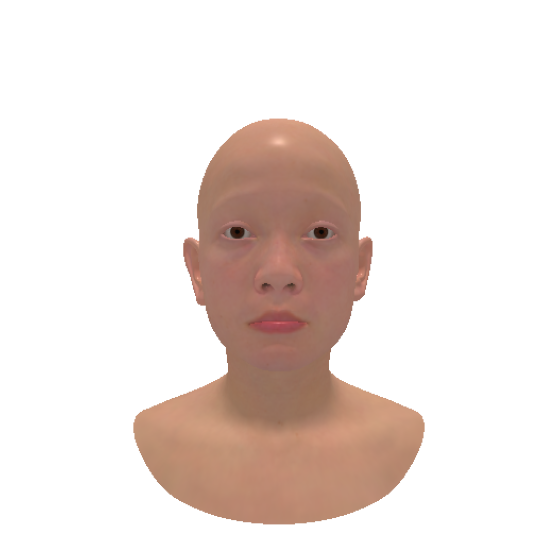

In [8]:
from matplotlib import pyplot as plt
obj_path = '/root/lib/3d/data/amelia/amelia_new.obj'

images = render_with_certain_view(obj_path, elev=-90, azim=180)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.axis("off")
plt.show()

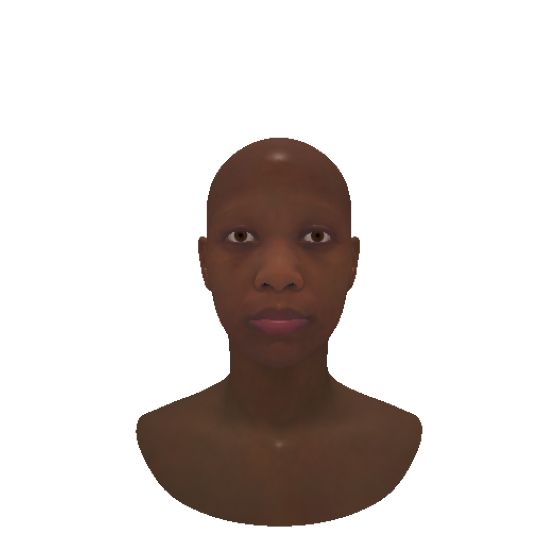

In [9]:
from matplotlib import pyplot as plt
obj_path = '/root/lib/3d/data/ada/ada_new.obj'

images = render_with_certain_view(obj_path, elev=-90, azim=180)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.axis("off")
plt.show()